In [34]:
# Load and clean data
def load_and_clean_data():
    url = 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2024.csv'
    df = pd.read_csv(url)

    # Filter Grand Slam matches
    df = df[df['tourney_level'] == 'G'].copy()

# Handle missing Elo ratings by filling with average Elo
    df['winner_elo'].fillna(df['winner_elo'].mean(), inplace=True)
    df['loser_elo'].fillna(df['loser_elo'].mean(), inplace=True)

# Create a list of unique players
    players = pd.unique(df[['winner_name', 'loser_name']].values.ravel('K'))

# Initialize a dictionary to store player Elo ratings
    player_elos = {player: 1500 for player in players}


    return df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_rank,winner_rank_points,loser_rank,loser_rank_points,seed_diff,winner_elo,loser_elo,elo_diff,seed_elo_interaction,winner_won
160,2023-580,Australian Open,Hard,128,G,1970-01-01 00:00:00.020230116,100,104745,1.0,NaN,...,2.0,5770.0,38.0,1020.0,1.0,1501.503117,1518.320932,-16.817815,-16.817815,1
253,2023-580,Australian Open,Hard,128,G,1970-01-01 00:00:00.020230116,193,105138,24.0,NaN,...,25.0,1675.0,215.0,255.0,24.0,1532.633557,1500.736307,31.897250,765.534000,1
252,2023-580,Australian Open,Hard,128,G,1970-01-01 00:00:00.020230116,192,104918,0.0,NaN,...,66.0,770.0,159.0,362.0,0.0,1516.815634,1486.338809,30.476826,0.000000,1
251,2023-580,Australian Open,Hard,128,G,1970-01-01 00:00:00.020230116,191,111581,0.0,LL,...,107.0,523.0,13.0,2560.0,-12.0,1535.445373,1548.978714,-13.533341,162.400095,1
250,2023-580,Australian Open,Hard,128,G,1970-01-01 00:00:00.020230116,190,200670,0.0,NaN,...,67.0,758.0,26.0,1550.0,-23.0,1518.832018,1485.595644,33.236374,-764.436613,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2023-560,Us Open,Hard,128,G,1970-01-01 00:00:00.020230828,134,208014,0.0,WC,...,110.0,547.0,98.0,603.0,0.0,1531.996001,1466.531169,65.464832,0.000000,1
2179,2023-560,Us Open,Hard,128,G,1970-01-01 00:00:00.020230828,133,111190,0.0,NaN,...,67.0,817.0,45.0,1025.0,0.0,1501.427716,1518.832018,-17.404303,-0.000000,1
2178,2023-560,Us Open,Hard,128,G,1970-01-01 00:00:00.020230828,132,134770,5.0,NaN,...,5.0,4715.0,154.0,402.0,5.0,1502.242112,1484.663760,17.578352,87.891759,1
2208,2023-560,Us Open,Hard,128,G,1970-01-01 00:00:00.020230828,162,126523,0.0,NaN,...,76.0,776.0,475.0,90.0,0.0,1478.297211,1485.811914,-7.514703,-0.000000,1


In [42]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


# Fill missing Elo ratings with the mean
df['winner_elo'].fillna(df['winner_elo'].mean(), inplace=True)
df['loser_elo'].fillna(df['loser_elo'].mean(), inplace=True)

# Prepare match dataset
matches = pd.DataFrame()
matches['player_1'] = df['winner_name']
matches['player_2'] = df['loser_name']
matches['player_1_elo'] = df['winner_elo']
matches['player_2_elo'] = df['loser_elo']
matches['surface'] = df['surface']
matches['player_1_rank'] = df['winner_rank']
matches['player_2_rank'] = df['loser_rank']
matches['outcome'] = 1

mirrored = matches.copy()
mirrored['player_1'] = matches['player_2']
mirrored['player_2'] = matches['player_1']
mirrored['player_1_elo'] = matches['player_2_elo']
mirrored['player_2_elo'] = matches['player_1_elo']
mirrored['player_1_rank'] = matches['player_2_rank']
mirrored['player_2_rank'] = matches['player_1_rank']
mirrored['outcome'] = 0

matches = pd.concat([matches, mirrored], ignore_index=True)
matches = pd.get_dummies(matches, columns=['surface'])



<ipython-input-42-ccf2e248d250>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['winner_elo'].fillna(df['winner_elo'].mean(), inplace=True)
<ipython-input-42-ccf2e248d250>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [43]:
# Train XGBoost model
features = ['player_1_elo', 'player_2_elo', 'player_1_rank', 'player_2_rank',
            'surface_Clay', 'surface_Grass', 'surface_Hard']
X = matches[features]
y = matches['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [44]:
# Simulate match
def predict_match(p1, p2, surface, player_stats, model):
    features = pd.DataFrame({
        'player_1_elo': [player_stats[p1]['elo']],
        'player_2_elo': [player_stats[p2]['elo']],
        'player_1_rank': [player_stats[p1]['rank']],
        'player_2_rank': [player_stats[p2]['rank']],
        'surface_Clay': [1 if surface == 'Clay' else 0],
        'surface_Grass': [1 if surface == 'Grass' else 0],
        'surface_Hard': [1 if surface == 'Hard' else 0]
    })
    prob = model.predict_proba(features)[0][1]
    return p1 if random.random() < prob else p2

In [45]:
# Simulate tournament with tracking
def simulate_and_track(players, surface, player_stats, model):
    rounds = [players]
    current = players
    while len(current) > 1:
        next_r = []
        for i in range(0, len(current), 2):
            winner = predict_match(current[i], current[i+1], surface, player_stats, model)
            next_r.append(winner)
        rounds.append(next_r)
        current = next_r
    return rounds

In [46]:
# Draw bracket
def draw_bracket(rounds):
    G = nx.DiGraph()
    pos = {}
    labels = {}
    for rnd, players in enumerate(rounds):
        for i, p in enumerate(players):
            node = f'{rnd}_{i}'
            G.add_node(node)
            pos[node] = (rnd, -i)
            labels[node] = p
            if rnd > 0:
                for j in range(2):
                    parent = f'{rnd-1}_{i*2+j}'
                    if parent in G:
                        G.add_edge(parent, node)
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1500, font_size=8, node_color='lightblue')
    plt.title("Tournament Bracket")
    plt.show()

In [47]:
# Monte Carlo simulation
def simulate_tournament_distribution(players, surface, player_stats, model, num_simulations=1000):
    winner_counter = Counter()
    for _ in range(num_simulations):
        random.shuffle(players)
        rounds = simulate_and_track(players, surface, player_stats, model)
        winner = rounds[-1][0]
        winner_counter[winner] += 1
    return winner_counter

In [48]:
# Prepare player stats from Elo and Rank
players_df = df[['winner_name', 'winner_elo', 'winner_rank']].dropna().drop_duplicates('winner_name')
player_stats = {row['winner_name']: {'elo': row['winner_elo'], 'rank': row['winner_rank']} for _, row in players_df.iterrows()}
top_players = list(player_stats.keys())[:128]

In [49]:
# Run and visualize Roland Garros
surface = 'Clay'
results = simulate_tournament_distribution(top_players, surface, player_stats, model, num_simulations=1000)
print("\nTop 5 Roland Garros Predictions:")
for player, wins in results.most_common(5):
    print(f"{player}: {wins / 1000:.2%}")


Top 5 Roland Garros Predictions:
Novak Djokovic: 94.90%
Tommy Paul: 2.20%
Stefanos Tsitsipas: 1.30%
Andrey Rublev: 1.00%
Daniil Medvedev: 0.20%


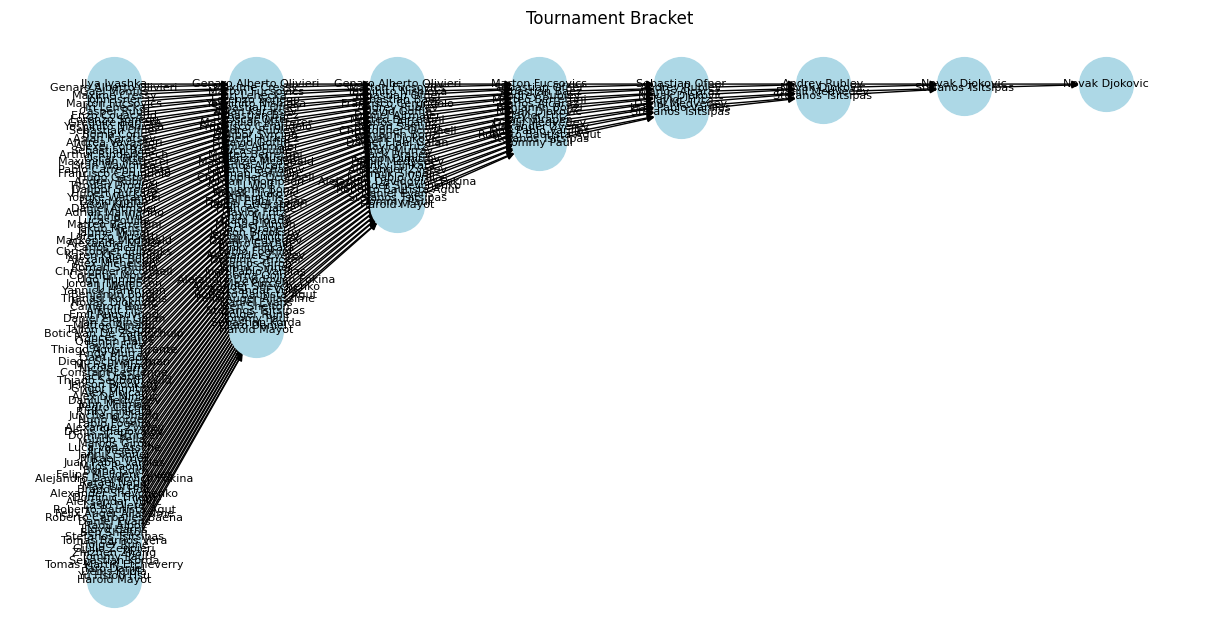

In [50]:
# Draw one simulation bracket
example_rounds = simulate_and_track(top_players, surface, player_stats, model)
draw_bracket(example_rounds)